# Calculating Betweenness Centrality using Python

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
ox.config(use_cache=True, log_console=True)

C:\Users\drn20\AppData\Local\Temp\ipykernel_9352\2883427635.py:5: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(use_cache=True, log_console=True)


Download OSM data for a specific place

In [2]:
graph = ox.graph_from_place('Heidelberg, Germany', network_type='drive')

Plot the graph

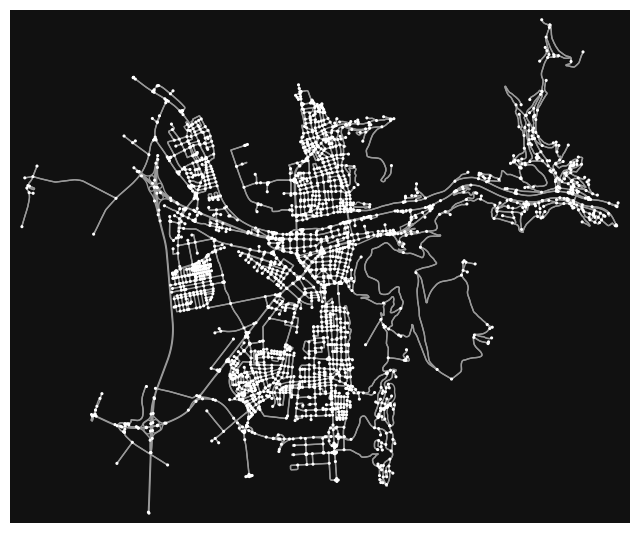

In [3]:
fig, ax = ox.plot_graph(graph, node_size=5)

### Centrality

Calculate betweenness centrality using the shortest routes (i.e. `weight='length'` means that we use the length of each edge).

In [4]:
betweenness_centrality = nx.edge_betweenness_centrality(graph, weight="length")

Convert the values in `betweenness_centrality` into a `pandas.Dataframe`.

In [5]:
centrality_df = pd.DataFrame(index=betweenness_centrality.keys(), data=betweenness_centrality.values())

Name the two index columns of the `centrality_df` 'u' and 'v'.

In [6]:
centrality_df.reset_index(inplace=True)
centrality_df.columns = ['u', 'v', 'key', 'centrality']
centrality_df = centrality_df.set_index(['u', 'v', 'key'])

In [11]:
centrality_df

centrality
u           v          key            
457111      457117     0      0.000000
            13888101   0      0.001821
468756      267042970  0      0.001740
            593007     0      0.000054
510913      1574280917 0      0.000349
...                                ...
11932808390 267164674  0      0.001047
            433220268  0      0.000001
12062036688 276772768  0      0.000349
12062036692 355897938  0      0.001420
            355897937  0      0.000082

[6675 rows x 1 columns]

Converting the graph to a `geopandas.GeoDataFrame` yields two dataframes. One for the nodes, and one for the edges.

In [7]:
nodes_df, edges_df = ox.graph_to_gdfs(graph)

Join the `centrality_df` with the `edges_df`.

In [8]:
centrality_gdf = centrality_df.join(edges_df[['osmid', 'geometry']])
centrality_gdf = gpd.GeoDataFrame(centrality_gdf, crs=4326)

In [12]:
centrality_gdf

centrality  \
u           v          key               
457111      457117     0      0.000000   
            13888101   0      0.001821   
468756      267042970  0      0.001740   
            593007     0      0.000054   
510913      1574280917 0      0.000349   
...                                ...   
11932808390 267164674  0      0.001047   
            433220268  0      0.000001   
12062036688 276772768  0      0.000349   
12062036692 355897938  0      0.001420   
            355897937  0      0.000082   

                                                                        osmid  \
u           v          key                                                      
457111      457117     0    [24559588, 24559589, 143862037, 143862040, 614...   
            13888101   0                                            143862051   
468756      267042970  0                                [306700546, 24560772]   
            593007     0                               [191139657, 143865915]   
510913      1574280917 0    [191139655, 4643062, 78781591, 348374905, 3483...   
...                                                                       ...   
11932808390 267164674  0                                [225564945, 24573324]   
            433220268  0                                            250271500   
12062036688 276772768  0                                 [25793216, 25793215]   
12062036692 355897938  0                                             76903629   
            355897937  0                               [1302363072, 31789285]   

                                                                     geometry  
u           v          key                                                     
457111      457117     0    LINESTRING (8.63495 49.41151, 8.63483 49.41186...  
            13888101   0    LINESTRING (8.63495 49.41151, 8.63492 49.41194...  
468756      267042970  0    LINESTRING (8.63309 49.37625, 8.63294 49.37608...  
            593007     0    LINESTRING (8.63309 49.37625, 8.63285 49.37549...  
510913      1574280917 0    LINESTRING (8.63153 49.35323, 8.63157 49.35408...  
...                                                                       ...  
11932808390 267164674  0    LINESTRING (8.61514 49.37381, 8.61518 49.37388...  
            433220268  0    LINESTRING (8.61514 49.37381, 8.61519 49.37379...  
12062036688 276772768  0    LINESTRING (8.66944 49.37451, 8.66947 49.37454...  
12062036692 355897938  0    LINESTRING (8.66718 49.37823, 8.66719 49.37821...  
            355897937  0    LINESTRING (8.66718 49.37823, 8.66679 49.37895...  

[6675 rows x 3 columns]

Now that the centrality values have been joined with the edges which include the geometries, we can plot the centrality values of the road network on a map using the `geopandas.explore()` function.

In [9]:
centrality_gdf.explore(column='centrality', cmap='magma_r', tiles='cartodbpositron')

### Betweenness centrality using the fastest routes
Calculate centrality using the fastest route instead of the shortest route.


1. Assign travel speed values to each edge using the `ox.add_edge_speeds` function. **Fill in the missing road types in the dictionary below** based on the [openrouteservice documetation on travel speeds](https://giscience.github.io/openrouteservice/documentation/travel-speeds/Waytype-Speeds.html).

In [10]:
hwy_speeds = {'motorway': 130,
              'trunk': 100,
              'residential': 60,
              'tertiary': 60} #etc
graph_with_speeds = ox.add_edge_speeds(graph, hwy_speeds)

2. Calculate the travel time for each edge using the `ox.add_edge_travel_times` function.

In [14]:
# Add edge travel time(seconds) to graph as a new travel_time edge attribute
graph_with_travel_time = ox.add_edge_travel_times(graph)

3. Calculate betweenness centrality again using the `nx.edge_betweenness_centrality` but pass `weight="travel_time` as an argument.


In [15]:
betweenness_centrality_time = nx.edge_betweenness_centrality(graph, weight="travel_time")

4. Convert the centrality value to a `pandas.DataFrame` and join it with the `edges_df` dataframe as above and visualize the result in a map.

### Geographically adapted betweenness centrality

1. Get start and destination nodes in the graph from geographic coordinates using the `nearest_nodes` function.

In [ ]:
origin_node =

In [ ]:
destination_node =

2. Calculate route between the two nodes using the `ox.shortest_path()` function.

3. Plot the route using

In [ ]:
fig, ax = ox.plot_graph_route(graph, route, route_color="y", route_linewidth=6, node_size=0)

4. Convert the route to a `geopandas.GeoDataFrame` using the `ox.utils_graph.route_to_gdf`.

5. Generate 100 routes by choosing random start and endpoints.

6. Merge all route dataframes using the `pd.concat` function

7. Calculate betweenness centrality indicator of the graph by grouping the routes by the columns 'u', 'v' and 'key' and counting the number of features.

8. Join the dataframe containing the manually computed centrality values with the `edges_df` dataframe. Plot the manually computed betweenness centrality on an interactive map.

 ### Bonus

Write a function which chooses a start and destination node from the graph based on the population distribution from the [Global Human Settlement population layer](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop).

